In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split

from nba_api.stats.endpoints import leaguegamefinder
from nba_api.stats.static import teams

# Gets the box score of every single game (NBA + WNBA + others: nba.com doesn't seperate the leagues) 
# from 2014-2021 into a dataframe.
all_games_finder = leaguegamefinder.LeagueGameFinder()
all_games = all_games_finder.get_data_frames()[0]

# Creates empty dataframe with the same column names passed in from the dataframe containing all the games.
column_names = all_games.columns
games = pd.DataFrame(columns = column_names)

# Appends every game containing an NBA team in the all_games df to the games df. 
nba_teams = teams.get_teams()
for team in nba_teams:
    temp_id = team['id']
    games = games.append(all_games[all_games['TEAM_ID'] == temp_id])

games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18000 entries, 5 to 29995
Data columns (total 28 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   SEASON_ID          18000 non-null  object 
 1   TEAM_ID            18000 non-null  object 
 2   TEAM_ABBREVIATION  18000 non-null  object 
 3   TEAM_NAME          18000 non-null  object 
 4   GAME_ID            18000 non-null  object 
 5   GAME_DATE          18000 non-null  object 
 6   MATCHUP            18000 non-null  object 
 7   WL                 17992 non-null  object 
 8   MIN                18000 non-null  object 
 9   PTS                18000 non-null  object 
 10  FGM                18000 non-null  object 
 11  FGA                18000 non-null  object 
 12  FG_PCT             17998 non-null  float64
 13  FG3M               18000 non-null  object 
 14  FG3A               18000 non-null  object 
 15  FG3_PCT            17997 non-null  float64
 16  FTM                180

In [2]:
# Dropping any game (two rows in DF) that has any NaN values or is missing either team's stats
games.isna()
games.dropna(inplace=True)

games = games[games.duplicated(subset = ['GAME_ID'], keep=False)]
 
# Merging games together (previously seperated in the DF by team: each team's stats from the game were kept in seperate rows
games = games.sort_values(by=['GAME_ID'])
games = games.reset_index(drop=True)

games.MATCHUP = games.MATCHUP.apply(lambda x: 'home' if 'vs' in x else x)
games.MATCHUP = games.MATCHUP.apply(lambda x: 'away' if '@' in x else x)

home = pd.DataFrame(columns = column_names)
away = pd.DataFrame(columns = column_names)

home = home.append(games[games['MATCHUP'] == 'home'])
away = away.append(games[games['MATCHUP'] == 'away'])

home = home.add_prefix('HOME_')
away = away.add_prefix('AWAY_')

home = home.reset_index(drop=True)
away = away.reset_index(drop=True)
games = home.join(away)

games.head(25)

,HOME_SEASON_ID,HOME_TEAM_ID,HOME_TEAM_ABBREVIATION,HOME_TEAM_NAME,HOME_GAME_ID,HOME_GAME_DATE,HOME_MATCHUP,HOME_WL,HOME_MIN,HOME_PTS,...,AWAY_FT_PCT,AWAY_OREB,AWAY_DREB,AWAY_REB,AWAY_AST,AWAY_STL,AWAY_BLK,AWAY_TOV,AWAY_PF,AWAY_PLUS_MINUS
0,12015,1610612746,LAC,LA Clippers,0011500001,2015-10-02,home,W,238,103,...,0.750,14,43,57,16,9,2,23,26,-7.0
1,12015,1610612753,ORL,Orlando Magic,0011500002,2015-10-03,home,L,240,100,...,0.743,7,34,41,30,7,2,13,15,6.0
2,12015,1610612754,IND,Indiana Pacers,0011500003,2015-10-03,home,L,241,105,...,0.676,19,36,55,16,9,3,11,22,5.0
3,12015,1610612747,LAL,Los Angeles Lakers,0011500004,2015-10-04,home,L,238,71,...,0.708,12,48,60,20,9,4,14,21,19.0
4,12015,1610612761,TOR,Toronto Raptors,0011500005,2015-10-04,home,W,241,93,...,0.700,5,28,33,16,6,3,24,29,-20.0
5,12015,1610612748,MIA,Miami Heat,0011500006,2015-10-04,home,L,240,77,...,0.839,7,45,52,13,7,1,16,19,13.0
6,12015,1610612757,POR,Portland Trail Blazers,0011500007,2015-10-05,home,L,266,105,...,0.643,14,36,50,25,10,5,23,18,4.0
7,12015,1610612744,GSW,Golden State Warriors,0011500009,2015-10-05,home,W,240,95,...,0.826,15,33,48,15,10,0,14,19,-8.0
8,12015,1610612747,LAL,Los Angeles Lakers,0011500010,2015-10-07,home,L,265,114,...,0.684,13,32,45,27,13,5,22,40,3.0
9,12015,1610612764,WAS,Washington Wizards,0011500011,2015-10-06,home,W,240,129,...,0.667,6,36,42,22,6,8,23,20,-34.0


In [3]:
# Dropping Non-essential categorical data
games = games.drop(columns=['HOME_SEASON_ID', 'AWAY_SEASON_ID', 'HOME_TEAM_ID', 'AWAY_TEAM_ID', 'HOME_TEAM_NAME', 'AWAY_TEAM_NAME', 'HOME_MATCHUP', 'AWAY_MATCHUP', 'HOME_WL', 'AWAY_WL', 'HOME_GAME_DATE', 'AWAY_GAME_DATE']) 

# Storing some columns for future use
game_ids = games['HOME_GAME_ID'].values
minutes = games['HOME_MIN'].values
home_abrv = games['HOME_TEAM_ABBREVIATION'].values
away_abrv = games['AWAY_TEAM_ABBREVIATION'].values

# Dropping them for normalization and correlation heatmap
games = games.drop(columns=['HOME_GAME_ID', 'AWAY_GAME_ID', 'HOME_MIN', 'AWAY_MIN', 'HOME_TEAM_ABBREVIATION', 'AWAY_TEAM_ABBREVIATION'])

# Adding minutes back as a single column
games['MIN'] = minutes
games.head()

,HOME_PTS,HOME_FGM,HOME_FGA,HOME_FG_PCT,HOME_FG3M,HOME_FG3A,HOME_FG3_PCT,HOME_FTM,HOME_FTA,HOME_FT_PCT,...,AWAY_OREB,AWAY_DREB,AWAY_REB,AWAY_AST,AWAY_STL,AWAY_BLK,AWAY_TOV,AWAY_PF,AWAY_PLUS_MINUS,MIN
0,103,37,91,0.407,9,32,0.281,20,26,0.769,...,14,43,57,16,9,2,23,26,-7.0,238
1,100,39,89,0.438,6,26,0.231,16,19,0.842,...,7,34,41,30,7,2,13,15,6.0,240
2,105,38,92,0.413,10,35,0.286,19,31,0.613,...,19,36,55,16,9,3,11,22,5.0,241
3,71,26,90,0.289,6,23,0.261,13,21,0.619,...,12,48,60,20,9,4,14,21,19.0,238
4,93,31,73,0.425,2,11,0.182,29,36,0.806,...,5,28,33,16,6,3,24,29,-20.0,241


In [4]:
# Adding Advanced Stats to enhance model performance, formulas were gathered from various sources. 

# Efficient Field Goal Percentage
games['HOME_EFG%'] = (games['HOME_FGM'] + (.5 * games['HOME_FG3M'])) / games['HOME_FGA']
games['AWAY_EFG%'] = (games['AWAY_FGM'] + (.5 * games['AWAY_FG3M'])) / games['AWAY_FGA']

# Block Percentage
games['HOME_BLK%'] = (games['HOME_BLK'] / (games['AWAY_FGA']-games['AWAY_FG3A'])) * 100
games['AWAY_BLK%'] = (games['AWAY_BLK'] / (games['HOME_FGA']-games['HOME_FG3A'])) * 100

# Turnover Percentage
games['HOME_TOV%'] = games['HOME_TOV'] / (games['HOME_FGA'] + 0.44 * games['HOME_FTA'] + games['HOME_TOV'])
games['AWAY_TOV%'] = games['AWAY_TOV'] / (games['AWAY_FGA'] + 0.44 * games['AWAY_FTA'] + games['AWAY_TOV'])

#Offensive Rebound Percentage
games['HOME_ORB%'] = games['HOME_OREB'] / (games['HOME_OREB'] + games['AWAY_DREB'])
games['AWAY_ORB%'] = games['AWAY_OREB'] / (games['AWAY_OREB'] + games['HOME_DREB'])

#Defensive Rebound Percentage
games['HOME_DREB%'] = games['HOME_DREB'] / (games['AWAY_OREB'] + games['HOME_DREB'])
games['AWAY_DREB%'] = games['AWAY_DREB'] / (games['HOME_OREB'] + games['AWAY_DREB'])

# Possessions
#games["POSS"] = 0.5*((games["FGA"] + 0.4*games["FTA"] - 1.07*(games["OREB"]/(games["OREB"] + games["OREB_other"])) * (games["FGA"] - games["FGM"]) + games["TOV"]) + games["FGA_other"] + 0.4*games["FTA_other"] - 1.07 * (games["OREB_other"] / (games["OREB_other"] + games["DREB"])) * (games["FGA_other"] - games["FGM_other]) + games["TOV_other"]))

# ***Placeholder POSS***
games['HOME_POSS'] = 0.96*((games['HOME_FGA']) + games['HOME_TOV'] + 0.44 * games['HOME_FTA'] - games['HOME_OREB'])
games['AWAY_POSS'] = 0.96*((games['AWAY_FGA']) + games['AWAY_TOV'] + 0.44 * games['AWAY_FTA'] - games['AWAY_OREB'])

# Steals Percentage
games['HOME_STL%'] = 100 * (games['HOME_STL'] / games['AWAY_POSS'])
games['AWAY_STL%'] = 100 * (games['AWAY_STL'] / games['HOME_POSS'])

# Free Throw Rate
games['HOME_FTR'] = games['HOME_FTM'] / games['HOME_FGA']
games['AWAY_FTR'] = games['AWAY_FTM'] / games['AWAY_FGA']

# True Shooting (Requires True Shooting Attempts)
home_tsa = games['HOME_FGA'] + 0.44 * games['HOME_FTA']
away_tsa = games['AWAY_FGA'] + 0.44 * games['AWAY_FTA']
games['HOME_TS'] = games['HOME_PTS'] / (2 * home_tsa)
games['AWAY_TS'] = games['AWAY_PTS'] / (2 * away_tsa)

# Assist Rate
games['HOME_ASTR'] = 100 * games['HOME_AST'] / (games['HOME_FGA'] + (.44 * games['HOME_FTA']) + games['HOME_AST'] + games['HOME_TOV'])
games['AWAY_ASTR'] = 100 * games['AWAY_AST'] / (games['AWAY_FGA'] + (.44 * games['AWAY_FTA']) + games['AWAY_AST'] + games['AWAY_TOV'])

# Total Rebound Percentage
games['HOME_TRB%'] = 100 * (games['HOME_REB'] * (games['HOME_REB'] / 5)) / (games['MIN'] * (games['HOME_REB'] + games['AWAY_REB']))
games['AWAY_TRB%'] = 100 * (games['AWAY_REB'] * (games['AWAY_REB'] / 5)) / (games['MIN'] * (games['AWAY_REB'] + games['HOME_REB']))

# PACE
games['HOME_PACE'] = 48 * (games['HOME_POSS'] + games['AWAY_POSS']) / (2 * (games['MIN'] / 5))
games['AWAY_PACE'] = 48 * (games['AWAY_POSS'] + games['HOME_POSS']) / (2 * (games['MIN'] / 5))

# Offensive Rating
games['HOME_ORTG'] = 100 * (games['HOME_PTS'] / games['HOME_POSS'])
games['AWAY_ORTG'] = 100 * (games['AWAY_PTS'] / games['AWAY_POSS'])

# Defensive Rating
games['HOME_DRTG'] = 100 * (games['AWAY_PTS'] / games['HOME_POSS'])
games['AWAY_DRTG'] = 100 * (games['HOME_PTS'] / games['AWAY_POSS'])
games.head(10)

,HOME_PTS,HOME_FGM,HOME_FGA,HOME_FG_PCT,HOME_FG3M,HOME_FG3A,HOME_FG3_PCT,HOME_FTM,HOME_FTA,HOME_FT_PCT,...,HOME_ASTR,AWAY_ASTR,HOME_TRB%,AWAY_TRB%,HOME_PACE,AWAY_PACE,HOME_ORTG,AWAY_ORTG,HOME_DRTG,AWAY_DRTG
0,103,37,91,0.407,9,32,0.281,20,26,0.769,...,16.006985,11.869436,1.331408,2.844013,102.247261,102.247261,100.800138,95.419847,93.949643,102.377545
1,100,39,89,0.438,6,26,0.231,16,19,0.842,...,16.747868,22.488756,1.962209,1.628876,93.0048,93.0048,106.991235,114.540111,113.410709,108.056708
2,105,38,92,0.413,10,35,0.286,19,31,0.613,...,14.419116,10.937927,2.726531,2.145618,104.167568,104.167568,102.564704,102.968488,107.448737,98.288102
3,71,26,90,0.289,6,23,0.261,13,21,0.619,...,8.925673,15.610365,1.792717,2.80112,94.076773,94.076773,75.28332,97.534332,95.42956,76.943751
4,93,31,73,0.425,2,11,0.182,29,36,0.806,...,9.256143,13.355593,2.360535,1.115722,94.47356,94.47356,98.011938,76.96525,76.934102,98.051619
5,77,30,81,0.370,3,16,0.188,14,20,0.700,...,15.472313,11.145405,1.92,2.253333,91.8912,91.8912,84.607947,97.00952,98.892405,82.997034
6,105,42,99,0.424,10,31,0.323,11,16,0.688,...,15.682175,16.521279,1.993218,1.842842,96.300271,96.300271,99.395674,101.087666,103.182176,97.378027
7,95,35,70,0.500,7,17,0.412,18,24,0.750,...,22.914033,12.085079,1.342157,2.258824,90.0864,90.0864,105.769916,96.286655,96.862976,105.140601
8,114,36,83,0.434,7,26,0.269,35,46,0.761,...,11.574074,18.402399,1.475208,1.777095,93.446762,93.446762,109.709904,114.200712,112.597007,111.272489
9,129,48,96,0.500,15,26,0.577,18,22,0.818,...,23.124358,16.305959,2.068352,1.651685,104.448,104.448,121.408565,92.553623,89.409409,125.678077


In [5]:
# Converting entire DF to numeric
games = games.apply(pd.to_numeric, errors='coerce')

# Doing data normalization
realcols = list(games.columns.values)

for col in realcols:
  mean = games[col].mean()
  std = games[col].std()
  games[col] = (games[col] - mean)/std

# New DF's for heatmap correlations
pointsMap = games.copy()
plusminusMap = games.copy()

pointsMap = pointsMap.drop(columns=['HOME_PLUS_MINUS', 'AWAY_PLUS_MINUS'])
plusminusMap = plusminusMap.drop(columns=['HOME_PTS', 'AWAY_PTS'])

In [6]:
# Update CSV
games_csv = games
games_csv.to_csv("games_updated.csv")

<AxesSubplot:>

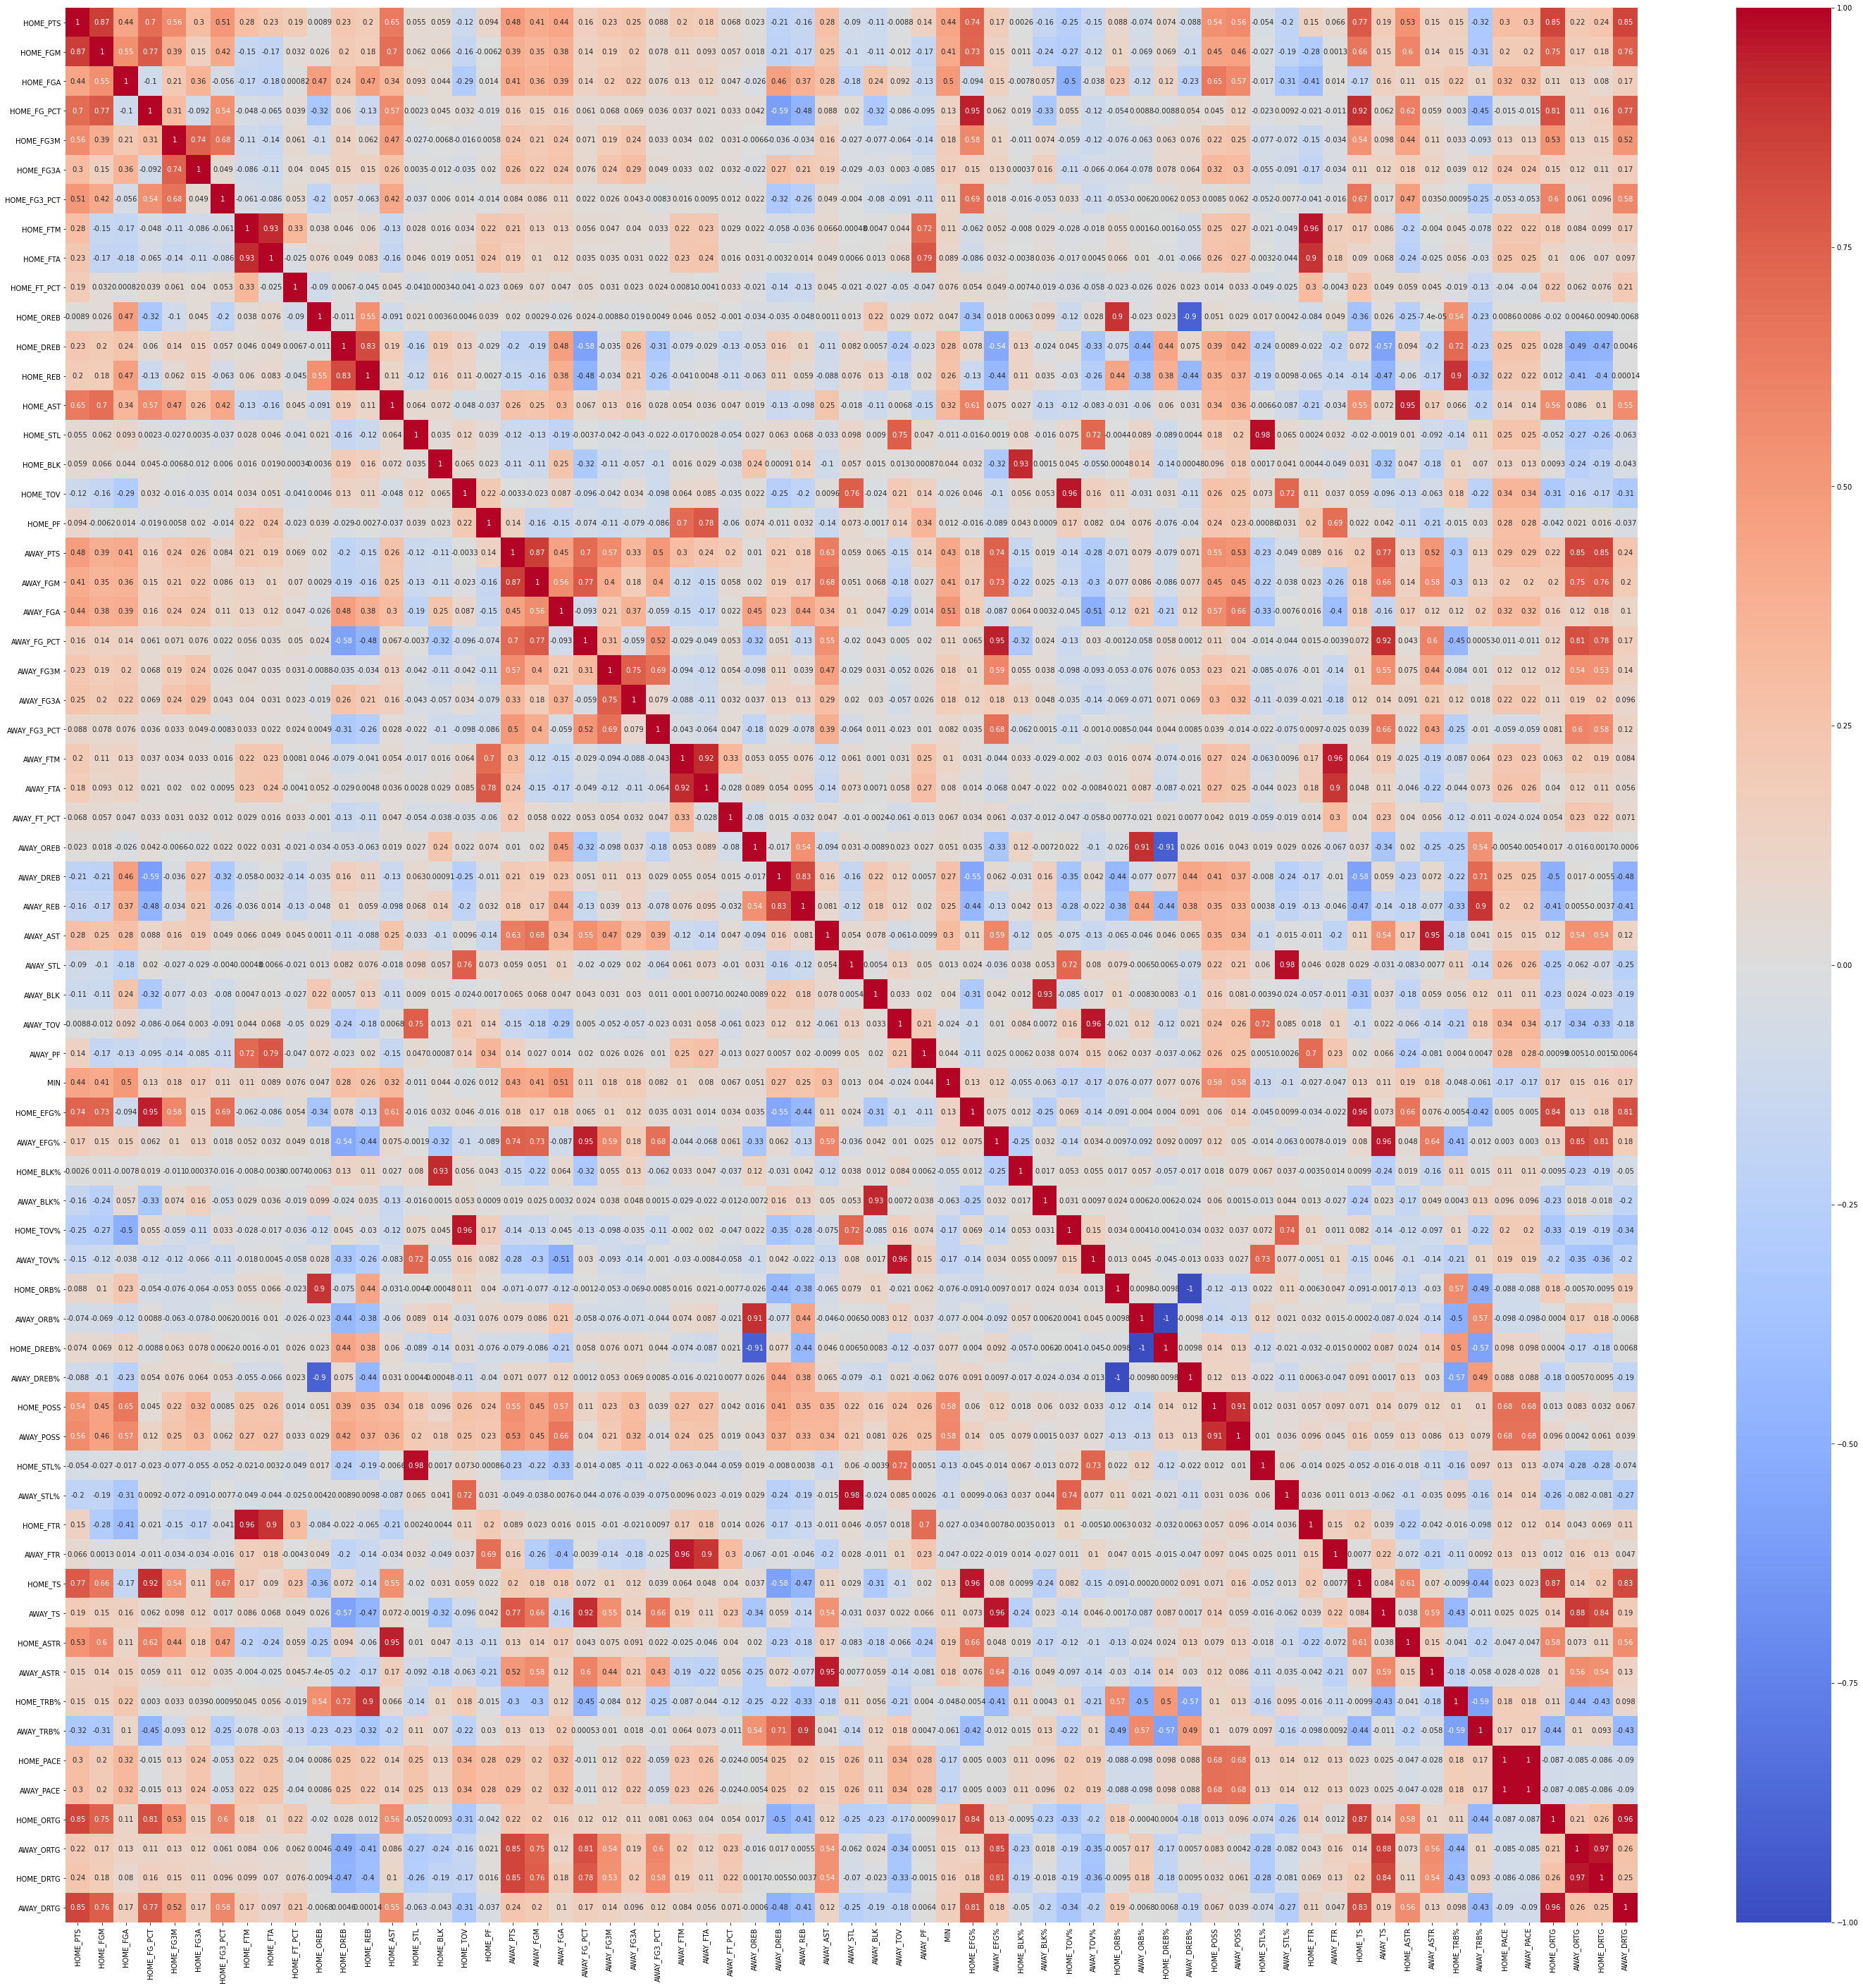

In [7]:
#Data Visualization
plt.figure(figsize=(50,50))
sns.heatmap(pointsMap.corr(),annot = True, cmap='coolwarm', vmin = -1)

<AxesSubplot:>

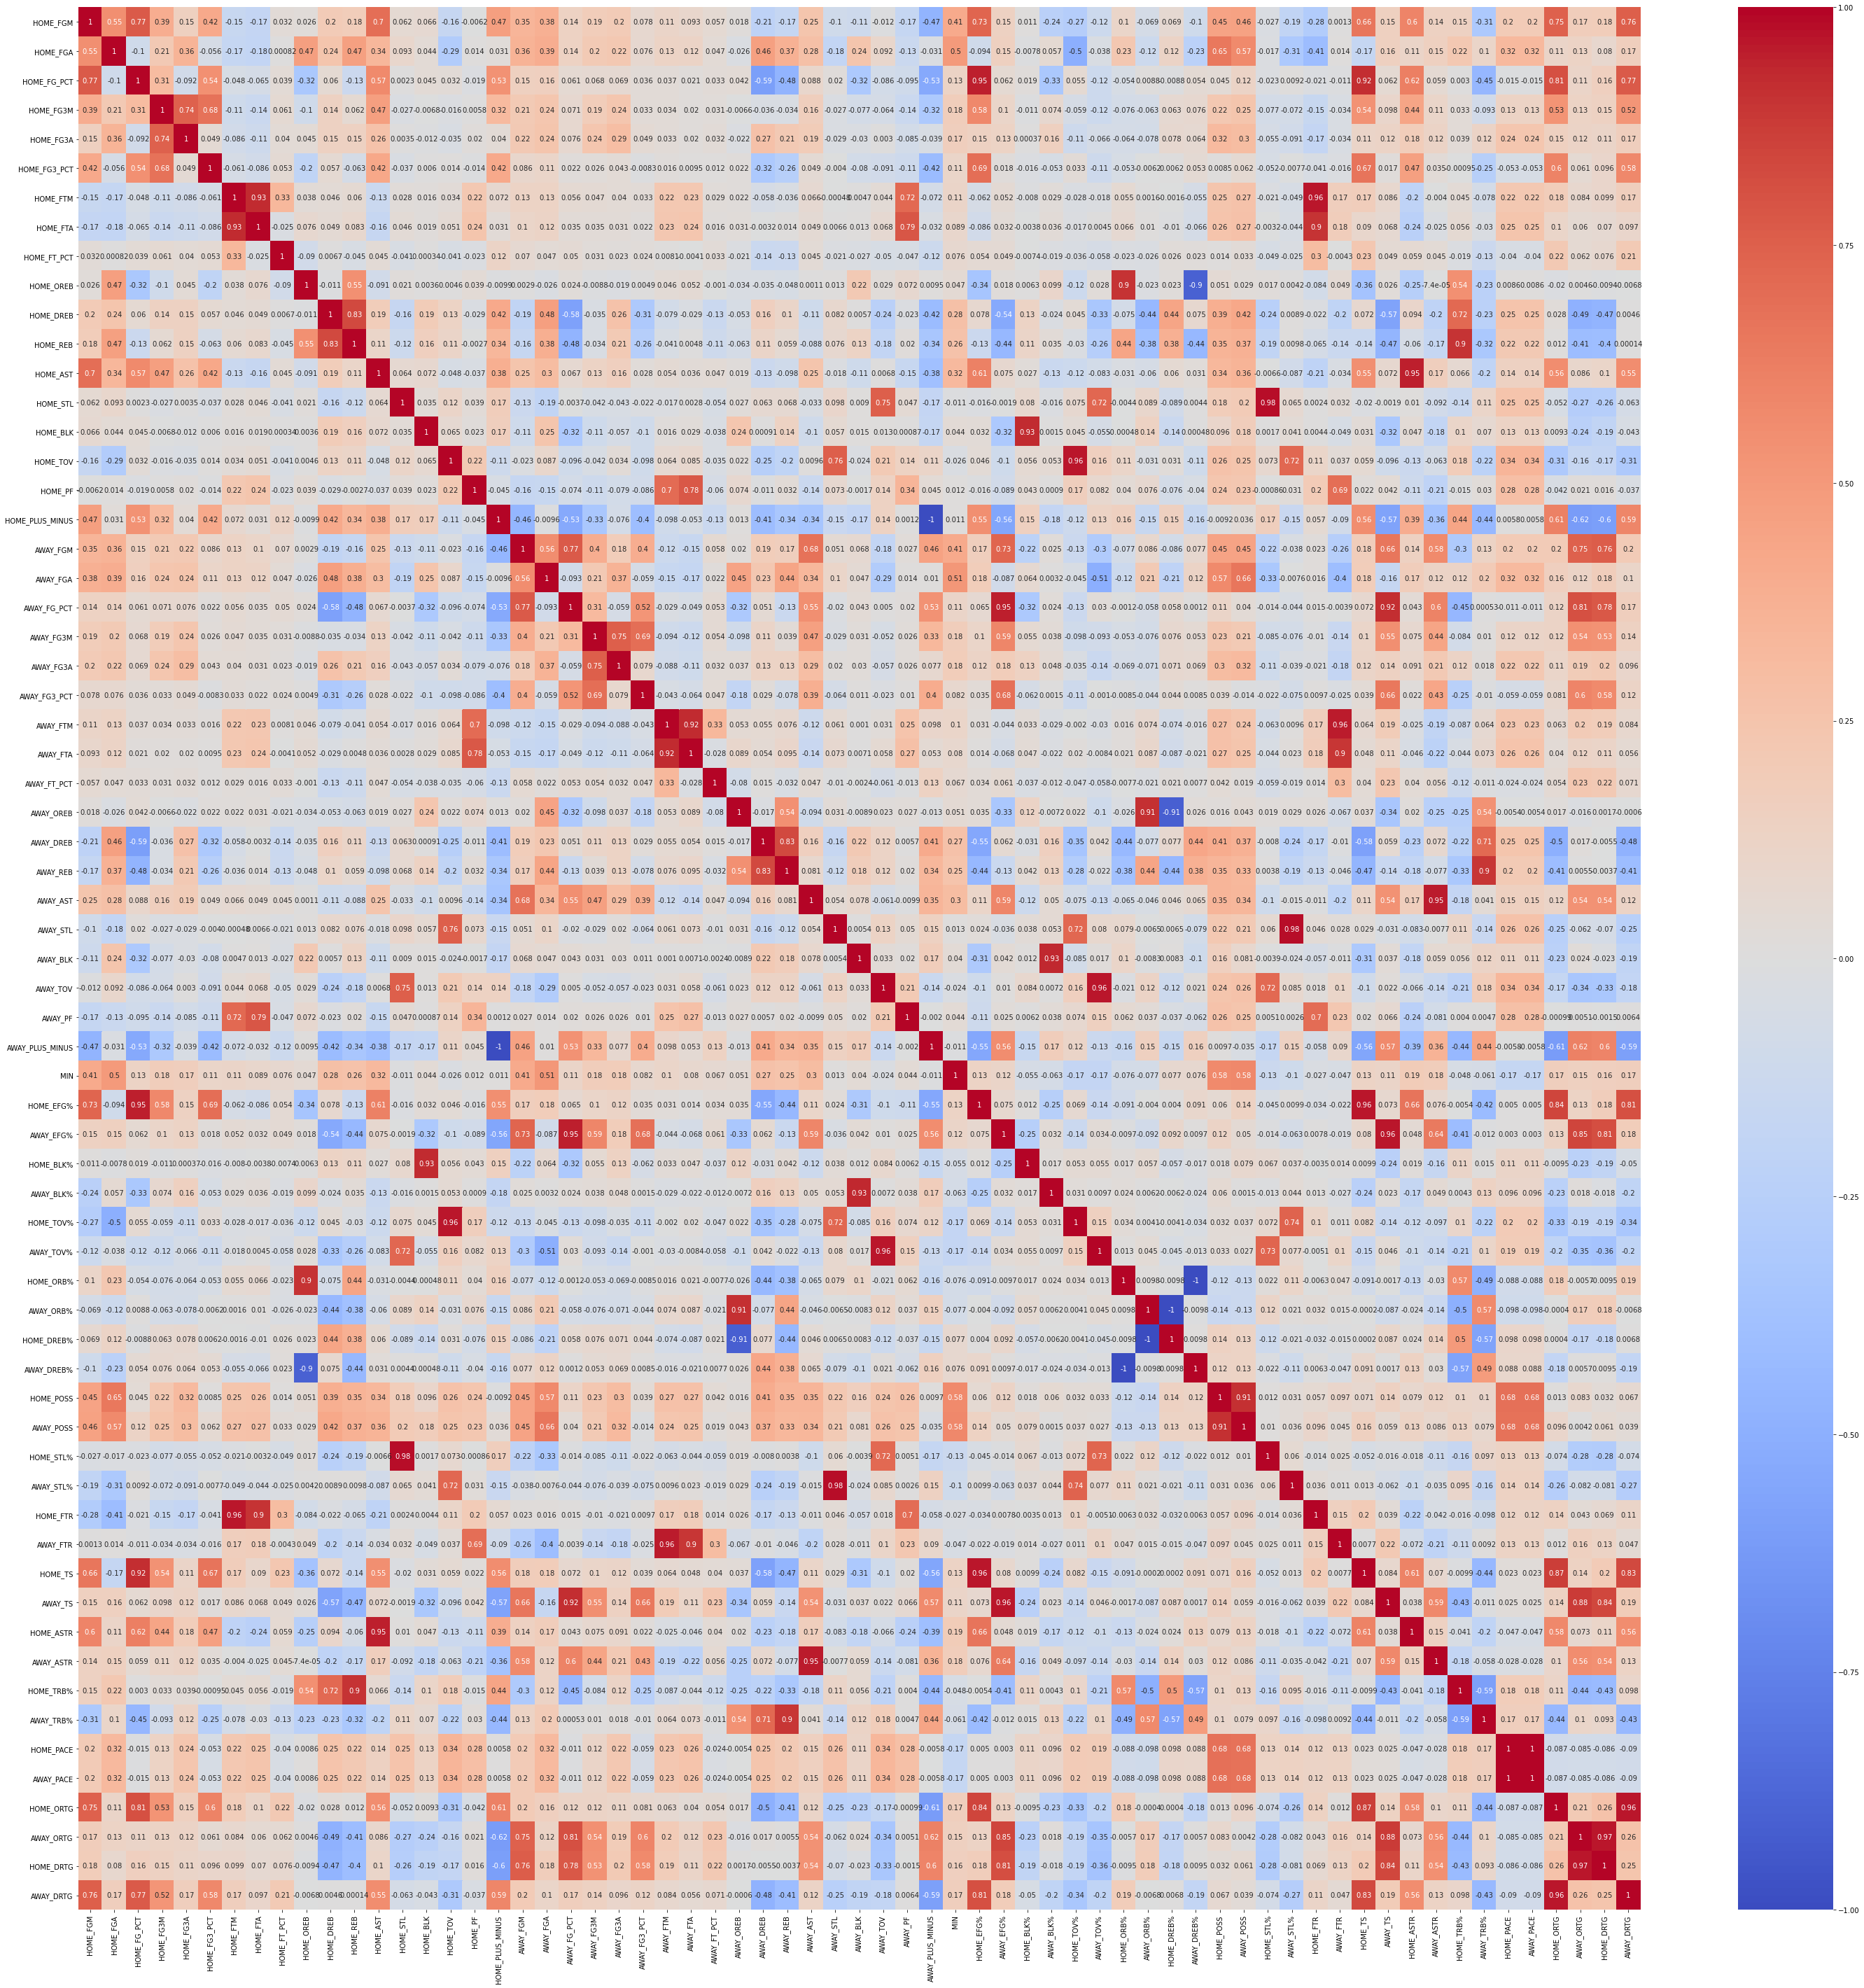

In [8]:
plt.figure(figsize=(50,50))
sns.heatmap(plusminusMap.corr(),annot = True, cmap='coolwarm', vmin = -1)

In [9]:
# ~ TO-DO: 
#  > simple statistics for each feature; mean, median, nth quartile, ...
#  > simple histogram; just to show basic statistics
#  > cleanup, normalize data (???)
#  > udpate document report